In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic
from stack_segmentation.training import handle_stacks_data, make_model, train_loop
from stack_segmentation.unet import UNet
from stack_segmentation.pipeline_config import dataloaders_conf, model_conf, train_conf

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
# train_conf['device'] = 'cpu'
# model_conf['device'] = 'cpu'

In [8]:
data_conf['conf_name'] = 'basic'
data_conf

{'conf_name': 'basic',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(None, Non

In [9]:
dataloaders_conf['train']['augmentation_pipeline'] = None
dataloaders_conf

{'train': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': None},
 'val': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': False,
  'augmentation_pipeline': None},
 'test': {'batch_size': 32,
  'num_workers': 8,
  'shuffle': True,
  'augmentation_pipeline': None}}

In [10]:
train_conf

{'num_epochs': 200, 'device': 'cuda:0'}

In [11]:
model_conf['opt_type'] = 'SGD'
model_conf['loss'] = [('BCE', 1)]
model_conf['weight'] = None
model_conf['nesterov'] = True
model_conf

{'device': 'cuda:0',
 'weight': None,
 'loss': [('BCE', 1)],
 'opt_type': 'SGD',
 'lr': 0.0001,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False,
 'min_lr': 1e-06,
 'factor': 0.5,
 'patience': 5}

In [12]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [13]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 702.53it/s]
100%|██████████| 720/720 [00:07<00:00, 93.06it/s] 
8280it [00:00, 233936.69it/s]
7920it [00:00, 228778.64it/s]
700it [00:00, 889.57it/s]
100%|██████████| 700/700 [00:06<00:00, 100.06it/s]
8280it [00:00, 231944.63it/s]
7920it [00:00, 81301.67it/s]
710it [00:00, 864.26it/s]
100%|██████████| 710/710 [00:07<00:00, 96.99it/s] 
7920it [00:00, 250935.85it/s]
7560it [00:00, 233328.95it/s]
720it [00:00, 808.64it/s]
100%|██████████| 720/720 [00:07<00:00, 94.47it/s] 
8280it [00:00, 243576.10it/s]
720it [00:00, 824.63it/s]
100%|██████████| 720/720 [00:07<00:00, 94.51it/s] 
25920it [00:00, 118795.44it/s]
700it [00:00, 853.71it/s]
100%|██████████| 700/700 [00:07<00:00, 99.16it/s] 
25200it [00:00, 128942.15it/s]
509it [00:00, 1204.23it/s]
100%|██████████| 509/509 [00:02<00:00, 198.35it/s]
8144it [00:00, 228473.66it/s]
700it [00:00, 830.61it/s]
100%|██████████| 700/700 [00:07<00:00, 98.17it/s] 
25200it [00:00, 230162.69it/s]
700it [00:00, 836.82it/s]
100%|██████████| 700/700 

In [14]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [15]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [16]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [17]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [18]:
model, criterion, optimizer, scheduler = make_model(**model_conf)

## Run experiment

In [19]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.56711


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.4114
Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.29025


100%|██████████| 732/732 [00:56<00:00, 12.90it/s]


Mean val loss: 0.20705


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.15998


100%|██████████| 732/732 [00:56<00:00, 12.89it/s]


Mean val loss: 0.12832


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.096337


100%|██████████| 732/732 [00:56<00:00, 12.89it/s]


Mean val loss: 0.075462


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.060946


100%|██████████| 732/732 [00:56<00:00, 12.87it/s]


Mean val loss: 0.054443
Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.047686


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.045701


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.041237


100%|██████████| 732/732 [00:56<00:00, 12.86it/s]


Mean val loss: 0.040622


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.037238


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.037209


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034443


100%|██████████| 732/732 [00:56<00:00, 12.86it/s]


Mean val loss: 0.034704


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.032364


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.032799


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 10...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03077


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.031318


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 11...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02952


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.030139


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.028516


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.029181


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027694


100%|██████████| 732/732 [00:56<00:00, 12.87it/s]


Mean val loss: 0.028387


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.027007


100%|██████████| 732/732 [00:56<00:00, 12.86it/s]


Mean val loss: 0.027719
Epoch 15...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.026423


100%|██████████| 732/732 [00:56<00:00, 12.86it/s]


Mean val loss: 0.027149


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02592


100%|██████████| 732/732 [00:56<00:00, 12.86it/s]


Mean val loss: 0.026649


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02548


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.026211


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 18...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.025092


100%|██████████| 732/732 [00:56<00:00, 12.84it/s]


Mean val loss: 0.025825


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 19...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.024744


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.025471


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 20...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.024429


100%|██████████| 732/732 [00:56<00:00, 12.84it/s]


Mean val loss: 0.025151


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02414


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.024854


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 22...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.023874


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.024584


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 23...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.023627


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.024329


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 24...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.023395


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.024092


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 25...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.023178


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.023867


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 26...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.022973


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.023671


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 27...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.022778


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.023458


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 28...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.022594


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.023268


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 29...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.022418


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.023088


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 30...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.022251


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.022926


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 31...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.022088


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.022749


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 32...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021933


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.022593


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 33...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021785


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.022445
Epoch 34...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02164


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.022299


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 35...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021499


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.022145


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021363


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.022016


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 37...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021232


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.021868


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 38...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.021102


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.02174


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 39...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020978


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.021631


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 40...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020855


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.021491


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020735


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.02136


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 42...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.02062


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.021241


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 43...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020507


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.021125


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 44...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020396


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.021014


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 45...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020288


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.020905


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 46...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020183


100%|██████████| 732/732 [00:56<00:00, 12.85it/s]


Mean val loss: 0.020798


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 47...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.020081


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.020693


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 48...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019982


100%|██████████| 732/732 [00:56<00:00, 12.84it/s]


Mean val loss: 0.0206


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 49...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019886


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.020504


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 50...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019792


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.020404


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 51...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019701


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.02031


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 52...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019612


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.020218


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 53...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019525


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.020134


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 54...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019442


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.020046


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 55...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01936


100%|██████████| 732/732 [00:57<00:00, 12.81it/s]


Mean val loss: 0.019963


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 56...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019279


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.019894


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 57...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019202


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.019814


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 58...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019126


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.019739


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 59...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.019052


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.019656


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 60...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018979


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.019593


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 61...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018909


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.019546


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 62...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018839


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.019441


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 63...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018772


100%|██████████| 732/732 [00:57<00:00, 12.81it/s]


Mean val loss: 0.019377


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 64...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018707


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018641


100%|██████████| 732/732 [00:57<00:00, 12.84it/s]


Mean val loss: 0.01924


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 66...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018576


100%|██████████| 732/732 [00:57<00:00, 12.81it/s]


Mean val loss: 0.019219


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 67...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018513


 89%|████████▉ | 653/732 [00:50<00:05, 13.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018072


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.018665


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 76...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.018023


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.018617


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 77...


 97%|█████████▋| 739/765 [02:34<00:05,  4.87it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017879


100%|██████████| 732/732 [00:57<00:00, 12.80it/s]


Mean val loss: 0.018481


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 80...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017835


100%|██████████| 732/732 [00:57<00:00, 12.80it/s]


Mean val loss: 0.018444


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 81...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017789


100%|██████████| 732/732 [00:57<00:00, 12.80it/s]


Mean val loss: 0.018391


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 82...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017745


100%|██████████| 732/732 [00:57<00:00, 12.80it/s]


Mean val loss: 0.018351


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 83...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017701


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.018292


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 84...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017659


100%|██████████| 732/732 [00:57<00:00, 12.81it/s]


Mean val loss: 0.01827


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 85...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017617


100%|██████████| 732/732 [00:57<00:00, 12.82it/s]


Mean val loss: 0.018205
Epoch 86...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017576


100%|██████████| 732/732 [01:08<00:00, 10.72it/s]


Mean val loss: 0.01817


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 87...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017534


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018199
EarlyStopping counter: 1 out of 10
Epoch 88...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017494


100%|██████████| 732/732 [01:48<00:00,  6.72it/s]


Mean val loss: 0.01809


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 89...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017454


100%|██████████| 732/732 [01:49<00:00,  6.70it/s]


Mean val loss: 0.018051


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 90...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017414


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.018001
Epoch 91...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017376


100%|██████████| 732/732 [01:49<00:00,  6.69it/s]


Mean val loss: 0.017967


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 92...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017338


100%|██████████| 732/732 [01:48<00:00,  6.72it/s]


Mean val loss: 0.017935


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 93...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.0173


100%|██████████| 732/732 [01:49<00:00,  6.71it/s]


Mean val loss: 0.017899


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 94...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017264


100%|██████████| 732/732 [01:49<00:00,  6.70it/s]


Mean val loss: 0.01785


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 95...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017226


100%|██████████| 732/732 [01:49<00:00,  6.71it/s]


Mean val loss: 0.017813


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 96...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01719


100%|██████████| 732/732 [01:48<00:00,  6.73it/s]


Mean val loss: 0.017814


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 97...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017154


100%|██████████| 732/732 [01:49<00:00,  6.71it/s]


Mean val loss: 0.017739


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 98...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01712


100%|██████████| 732/732 [01:49<00:00,  6.72it/s]


Mean val loss: 0.017705


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 99...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017084


100%|██████████| 732/732 [01:48<00:00,  6.72it/s]


Mean val loss: 0.017674


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 100...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017049


100%|██████████| 732/732 [01:49<00:00,  6.71it/s]


Mean val loss: 0.017631


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 101...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017016


100%|██████████| 732/732 [01:49<00:00,  6.71it/s]


Mean val loss: 0.017617


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 102...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016982


100%|██████████| 732/732 [01:48<00:00,  6.72it/s]


Mean val loss: 0.01757


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 103...


 48%|████▊     | 371/765 [02:44<02:51,  2.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [01:48<00:00,  6.73it/s]


Mean val loss: 0.017398


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 108...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016787


100%|██████████| 732/732 [01:48<00:00,  6.73it/s]


Mean val loss: 0.017373


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 109...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016757


 87%|████████▋ | 638/732 [01:34<00:13,  7.16it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [01:48<00:00,  6.74it/s]


Mean val loss: 0.017193


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 115...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016574


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.017257
EarlyStopping counter: 1 out of 10
Epoch 116...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016546


 49%|████▊     | 356/732 [00:54<00:55,  6.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016517


100%|██████████| 732/732 [01:48<00:00,  6.73it/s]


Mean val loss: 0.017111


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 118...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016489


100%|██████████| 732/732 [01:48<00:00,  6.72it/s]


Mean val loss: 0.017079


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 119...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016462


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016433


100%|██████████| 732/732 [00:56<00:00, 12.86it/s]


Mean val loss: 0.017015


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 121...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016405


100%|██████████| 732/732 [00:56<00:00, 12.87it/s]


Mean val loss: 0.01698


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 122...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016378


 61%|██████    | 445/732 [00:35<00:20, 13.83it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:57<00:00, 12.80it/s]


Mean val loss: 0.016771


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 130...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016169


100%|██████████| 732/732 [00:57<00:00, 12.80it/s]


Mean val loss: 0.016744


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 131...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.016143


100%|██████████| 732/732 [00:57<00:00, 12.83it/s]


Mean val loss: 0.016735


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 132...


 62%|██████▏   | 477/765 [01:40<00:59,  4.84it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015951


100%|██████████| 732/732 [00:57<00:00, 12.78it/s]


Mean val loss: 0.016531


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 140...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015928


100%|██████████| 732/732 [00:57<00:00, 12.79it/s]


Mean val loss: 0.016505


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 141...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015904


 70%|██████▉   | 511/732 [00:40<00:16, 13.73it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015729


100%|██████████| 732/732 [00:57<00:00, 12.75it/s]


Mean val loss: 0.016298


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 150...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015708


100%|██████████| 732/732 [00:57<00:00, 12.75it/s]


Mean val loss: 0.016279


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 151...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015686


 28%|██▊       | 205/732 [00:18<00:38, 13.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015546


100%|██████████| 732/732 [00:57<00:00, 12.72it/s]


Mean val loss: 0.016119


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 159...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015527


100%|██████████| 732/732 [00:57<00:00, 12.71it/s]


Mean val loss: 0.016097


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 160...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015508


100%|██████████| 732/732 [00:57<00:00, 12.72it/s]


Mean val loss: 0.016074


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 161...


 22%|██▏       | 166/765 [00:37<02:01,  4.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015359


100%|██████████| 732/732 [00:57<00:00, 12.77it/s]


Mean val loss: 0.015925
Epoch 169...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015342


100%|██████████| 732/732 [00:57<00:00, 12.74it/s]


Mean val loss: 0.01591


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 170...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015323


 80%|███████▉  | 585/732 [00:45<00:10, 13.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015204


100%|██████████| 732/732 [00:57<00:00, 12.75it/s]


Mean val loss: 0.015769


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 178...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015188


100%|██████████| 732/732 [00:57<00:00, 12.78it/s]


Mean val loss: 0.015764


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 179...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015173


100%|██████████| 732/732 [00:57<00:00, 12.74it/s]


Mean val loss: 0.015742


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 180...


 34%|███▍      | 261/765 [00:56<01:44,  4.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015047


100%|██████████| 732/732 [00:57<00:00, 12.76it/s]


Mean val loss: 0.015608


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 188...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015031


100%|██████████| 732/732 [00:57<00:00, 12.73it/s]


Mean val loss: 0.015616


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 189...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015016


100%|██████████| 732/732 [00:57<00:00, 12.75it/s]


Mean val loss: 0.015589


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 190...


 10%|█         | 80/765 [00:19<02:20,  4.88it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014902


100%|██████████| 732/732 [00:57<00:00, 12.74it/s]


Mean val loss: 0.015463


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 198...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014887


100%|██████████| 732/732 [00:57<00:00, 12.76it/s]


Mean val loss: 0.015471


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 199...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014873


 35%|███▌      | 257/732 [00:22<00:34, 13.80it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 788/788 [07:54<00:00,  2.00it/s]


## Dump experiment results

In [20]:
import pickle
import json

In [21]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [17]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [22]:
from itertools import chain

In [23]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [24]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

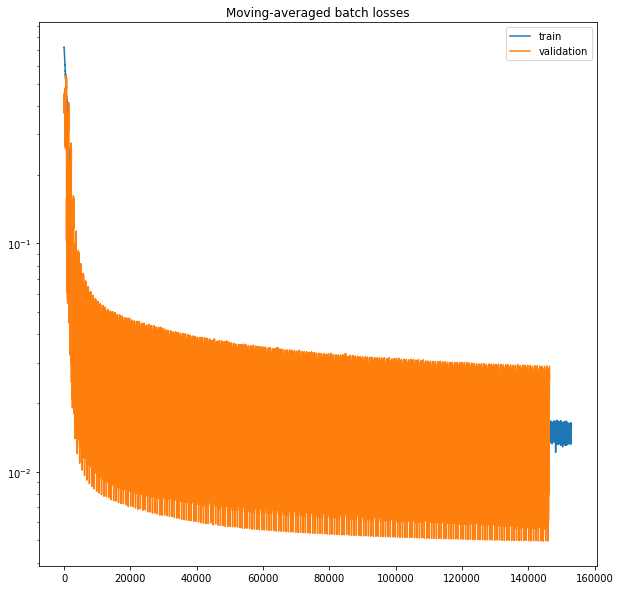

In [25]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [26]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

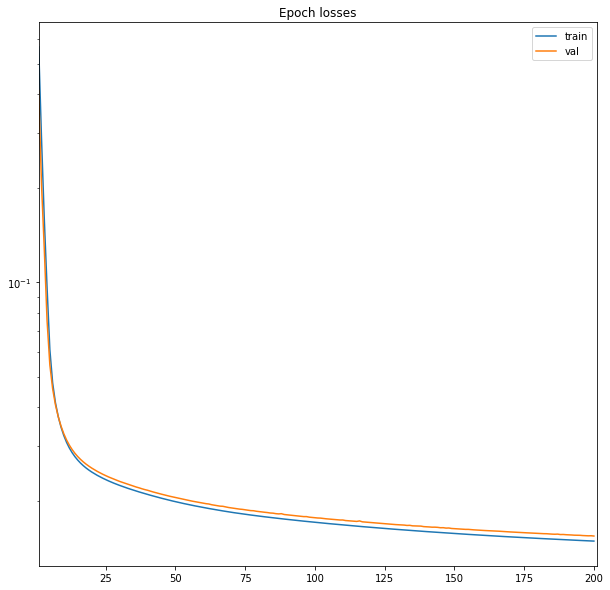

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [36]:
import pandas as pd

In [34]:
from visualization_utils import make_df

In [38]:
df = make_df(results, model_name='basic')
df

,accuracy,f1,iou,model,pr_auc,precision,recall,stack
0,0.993947,0.964771,0.931940,basic,0.996637,0.949369,0.980681,carb96558
1,0.988214,0.954243,0.912490,basic,0.993661,0.931258,0.978391,carb71
2,0.971020,0.858821,0.752573,basic,0.973521,0.983905,0.761953,carbRNF
3,0.991943,0.953144,0.910482,basic,0.997306,0.995782,0.914007,SPE_carb10_58_box3
4,0.988346,0.954144,0.912308,basic,0.996568,0.991205,0.919753,SoilAh-1
5,0.995804,0.959983,0.923045,basic,0.995040,0.960821,0.959145,SoilB-2
6,0.990033,0.966804,0.935740,basic,0.998345,0.994961,0.940196,TeTree_subset1
7,0.993355,0.968785,0.939461,basic,0.998390,0.994726,0.944164,TiTree_subset2
8,0.989746,0.959818,0.922741,basic,0.995083,0.966580,0.953150,Urna_22
9,0.989281,0.966135,0.934488,basic,0.996698,0.973305,0.959068,Urna_30


In [51]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.90667
Std    IOU: 0.052687
Min    IOU: 0.75257
Median IOU: 0.92274
